In [22]:
"""
GBDT + LogisticRegression
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap

%matplotlib inline

In [47]:
def plot_decision_regions(X, y, classifier=None, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    if classifier:
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=np.array([cmap(idx)]),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

# Make Moons function 介紹
畫出兩個月亮（上弦下弦），用來顯示出tree base的強大切割能力  
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

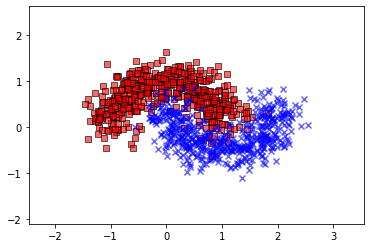

In [48]:
X, y = make_moons(n_samples=1000, noise=0.24, random_state=0)
X, y
plot_decision_regions(X,y)

noise越大，會越糊再一起

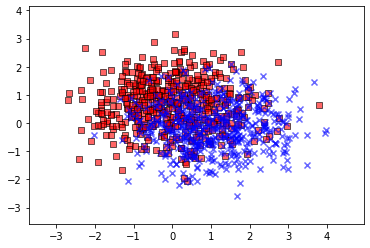

In [50]:
X, y = make_moons(n_samples=1000, noise=0.8, random_state=0)
X, y
plot_decision_regions(X,y)

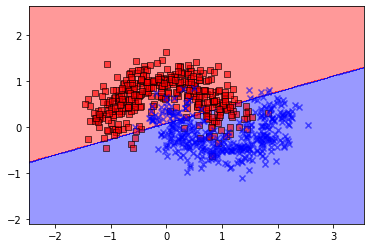

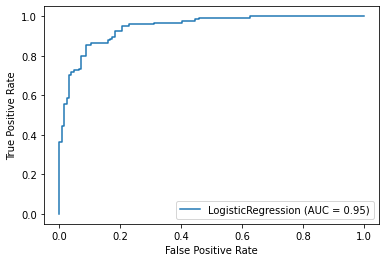

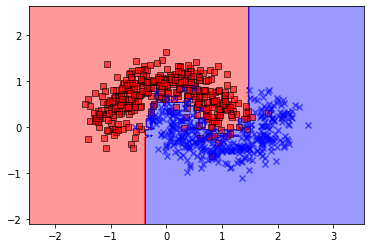

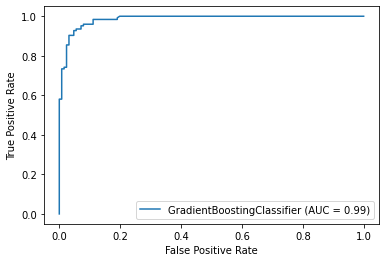

/Users/yehjames/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


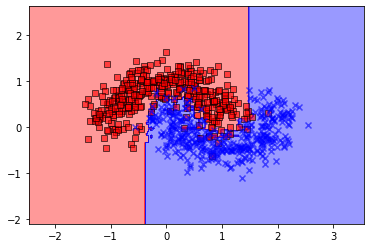

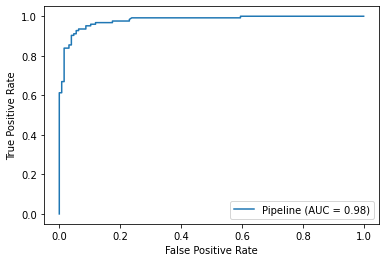

In [51]:
class GBDTTransformer(TransformerMixin):
    def __init__(self, n_estimators=200):
        self.n_estimators = n_estimators
        self.gbdt = GradientBoostingClassifier(n_estimators=n_estimators)
        self.gbdt_ohe = OneHotEncoder()
    def fit(self, X, y):
        self.gbdt.fit(X, y)
        self.gbdt_ohe.fit(self.gbdt.apply(X)[:, :, 0])
        return self
    def transform(self, X):
        return self.gbdt_ohe.transform(self.gbdt.apply(X)[:, :, 0])
if __name__ == '__main__':
    X, y = make_moons(n_samples=1000, noise=0.24, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifiers = [
        LogisticRegression(),
        GradientBoostingClassifier(),
        Pipeline([('gbdt', GBDTTransformer()),
                  ('lr', LogisticRegression())])
    ]
    for clf in classifiers:
        clf.fit(X_train, y_train)
        plot_decision_regions(X_train,y_train,clf)
        plt.show()
        disp = plot_roc_curve(clf, X_test, y_test)
        plt.show()


# 改用iris 資料集

In [7]:
from sklearn import datasets
import pandas as pd
import numpy as np
iris = datasets.load_iris()
x = pd.DataFrame(iris['data'], columns=iris['feature_names'])
print("target_names: "+str(iris['target_names']))
y = pd.DataFrame(iris['target'], columns=['target'])
iris_data = pd.concat([x,y], axis=1)
iris_data = iris_data[['petal width (cm)','petal length (cm)','target']]
iris_data.head(3)
X_train, X_test, y_train, y_test = train_test_split(
    iris_data[['petal width (cm)','petal length (cm)']], iris_data[['target']], test_size=0.3, random_state=0)

target_names: ['setosa' 'versicolor' 'virginica']


# RandomForest

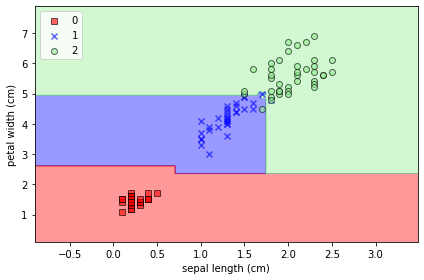

In [8]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators=10,random_state=3,n_jobs=2,max_features=2)
forest.fit(X_train,y_train['target'].values)
plot_decision_regions(X_train.values, y_train['target'].values, classifier=forest)
plt.xlabel('sepal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

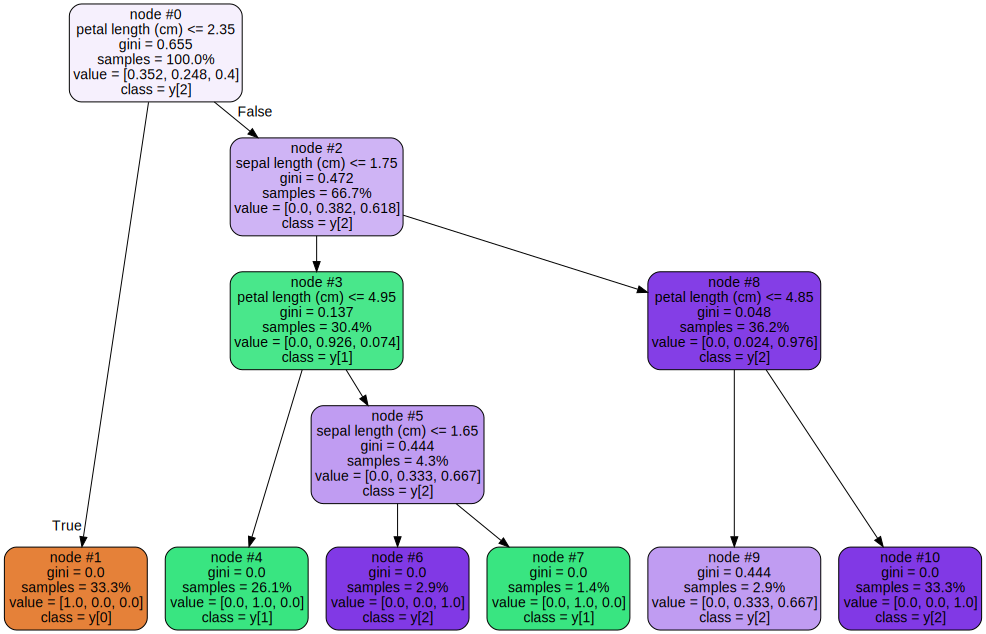

In [60]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(forest.estimators_[5],out_file=None, 
                           node_ids = True, 
                           feature_names=['sepal length (cm)','petal length (cm)'], 
                           proportion = True, 
                           class_names = True, 
                           filled = True, 
                           rounded = True,
                           leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph


In [15]:
print(X_test.values[:3])
forest.apply(X_test.values)[0]


[[2.4 5.1]
 [1.  4. ]
 [0.2 1.4]]


array([ 8, 14,  6,  8, 10, 10,  6, 10,  6,  8])

In [76]:
iris = datasets.load_iris()
x = pd.DataFrame(iris['data'], columns=iris['feature_names'])
print("target_names: "+str(iris['target_names']))
y = pd.DataFrame(iris['target'], columns=['target'])
iris_data = pd.concat([x,y], axis=1)
iris_data = iris_data[['sepal length (cm)','petal length (cm)','target']]
iris_data = iris_data[iris_data['target'].isin([1,2])]
iris_data.head(5)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    iris_data[['sepal length (cm)','petal length (cm)']], iris_data[['target']], test_size=0.3, random_state=0)

target_names: ['setosa' 'versicolor' 'virginica']


# GBDT 

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=10,random_state=3)
gbdt.fit(X_train,y_train['target'].values)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

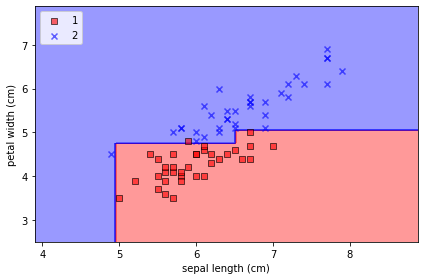

In [78]:
plot_decision_regions(X_train.values, y_train['target'].values, classifier=gbdt)
plt.xlabel('sepal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [63]:
iris['target_names']

array(['versicolor', 'virginica'], dtype='<U10')

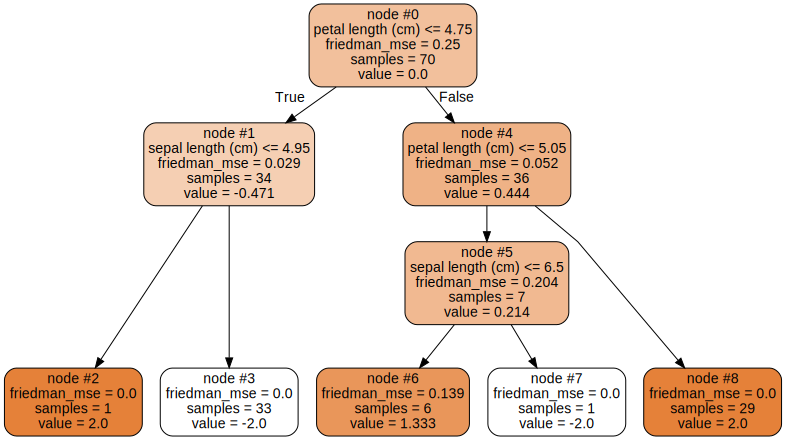

In [65]:
# GBDT使用回歸樹 
dot_data = export_graphviz(gbdt.estimators_[0, 0],
                           out_file=None, 
                           node_ids = True, 
                           feature_names=['sepal length (cm)','petal length (cm)'], 
                           proportion = False, 
                           class_names = ['versicolor', 'virginica'], 
                           filled = True, 
                           rounded = True,
                           leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph


In [36]:
print(X_test.values[:3])
gbdt.apply(X_test.values)

[[6.8 4.8]
 [6.3 5.6]
 [6.9 4.9]]


array([[[ 7.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.]],

       [[ 8.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.]],

       [[ 7.],
        [ 9.],
        [ 9.],
        [ 9.],
        [ 9.],
        [ 9.],
        [ 9.],
        [ 9.],
        [ 9.],
        [ 9.]],

       [[ 8.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.]],

       [[ 8.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.]],

       [[ 8.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.],
        [10.]],

       [[ 3.],
        [ 4.],
        [ 4.],
        [ 4.],
        [ 4.],
        [ 4.]

In [55]:
oc = OneHotEncoder()
oc.fit([[7],[5]])
oc.transform([[7],[5]]).toarray()

array([[0., 1.],
       [1., 0.]])